# Playground

In [251]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("./code")

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader

from dataset import *
from plots import *
from models import *

## Metadata Summary

In [30]:
metadata = load_metadata()

In [31]:
metadata.head()

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
0,0,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
1,1,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
2,2,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,2,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
3,3,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,3,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
4,4,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,4,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO


In [5]:
metadata.shape

(488396, 19)

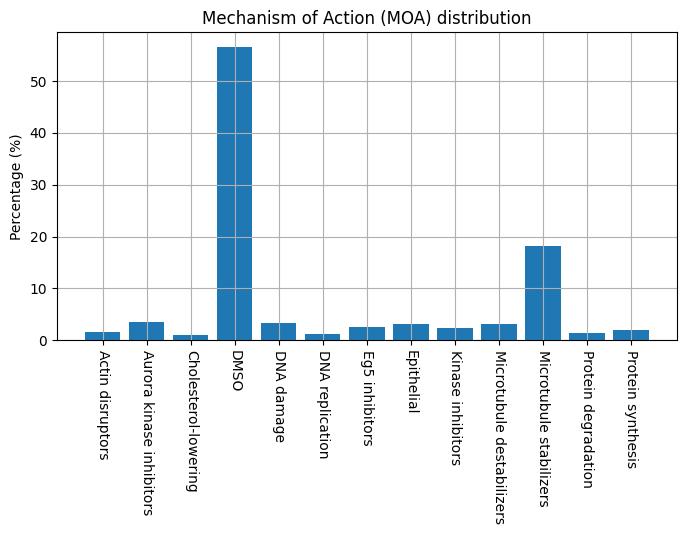

In [6]:
plot_MOA_distribution(metadata)

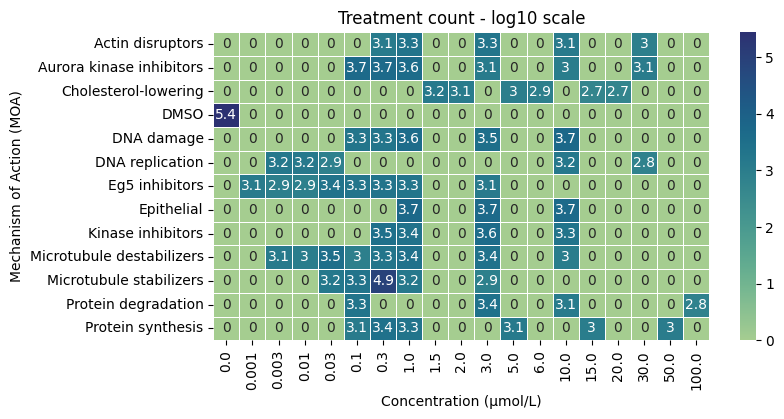

In [7]:
plot_treatment_heatmap(metadata)

## Small - Subset of Dataset

In [175]:
small_metadata = metadata[:4000]
images = load_images_from_metadata(small_metadata)
print(f"{images.shape[0]} images")

4000 images


In [ ]:
images = normalize_channel_wise(images)

In [ ]:
plot_treatment_heatmap(small_metadata)

## Tiny - Subset of Dataset

In [174]:
tiny_metadata = metadata[metadata["Multi_Cell_Image_Name"] == "Week10_200907_F02_s1_w14631241C-4FA2-4BC9-8693-D7D268CAEE82"]
#tiny_metadata = metadata[metadata["Multi_Cell_Image_Name"] == "B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10"]
images = load_images_from_metadata(tiny_metadata)
print(f"{images.shape[0]} images")

40 images


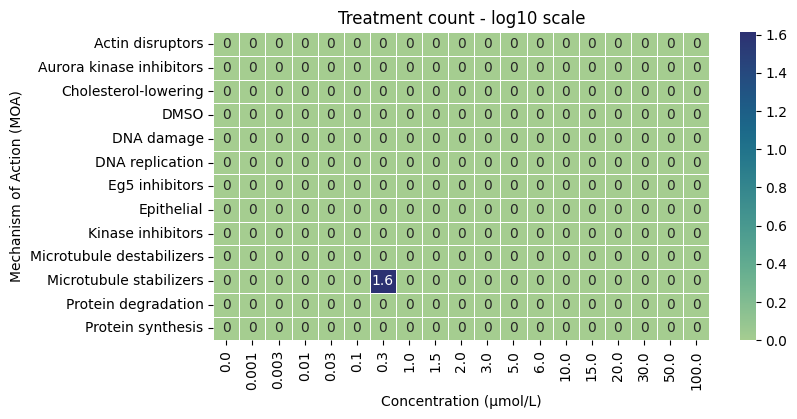

In [67]:
plot_treatment_heatmap(tiny_metadata)

In [68]:
images = normalize_channel_wise(images)
img1 = images[0]

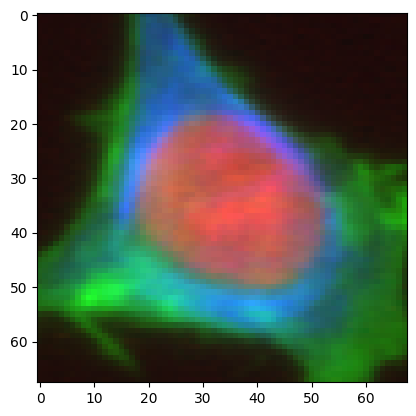

In [91]:
plot_image(img1)

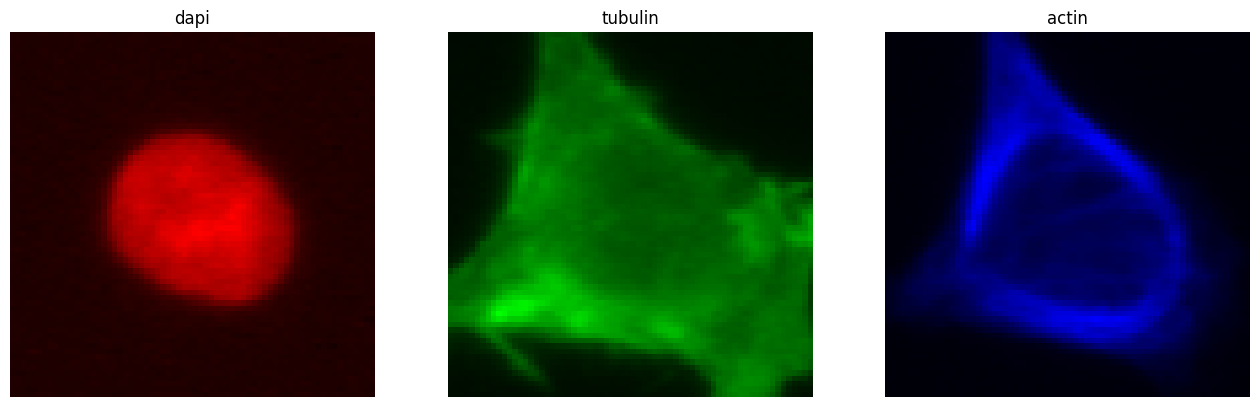

In [70]:
plot_channels(img1)

## Stratified - Subset of Dataset

In [265]:
stratified = stratify_metadata(metadata, 50)
images = load_images_from_metadata(stratified)

In [266]:
print(f"{images.shape[0]} images")

3300 images


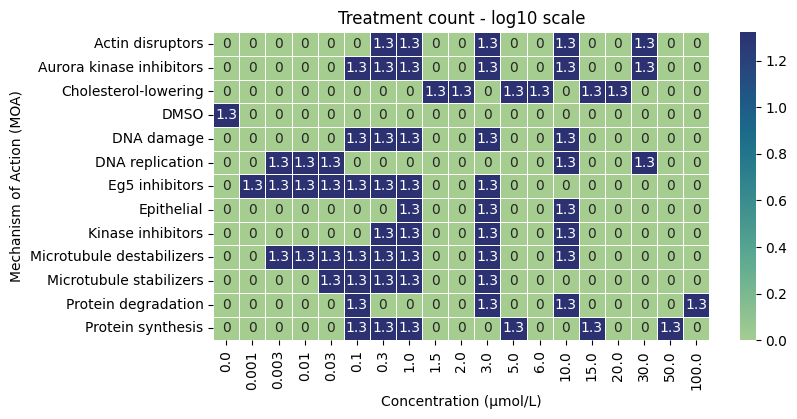

In [261]:
plot_treatment_heatmap(stratified)

## Model - Training

In [21]:
images = normalized_to_zscore(images)

In [234]:
print(f"{images.shape[0]} images")

6500 images


In [ ]:
cropped_images = view_cropped_images(images)
train(cropped_images, epochs=20, epoch_sample_times=2)

## Model - Load pretrained

In [ ]:
unet = UNet()
unet.load_state_dict(torch.load("./models/DDPM_Unconditional/ckpt.pt"))
diffusion = Diffusion()
sampled_images = diffusion.sample(unet, n=1)

## Results

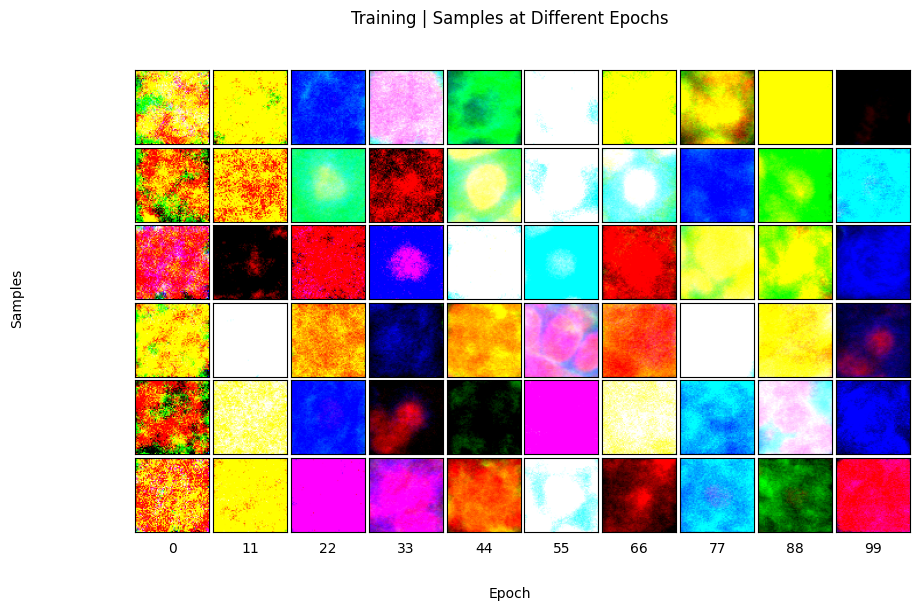

In [268]:
epoch_images, epochs = load_epoch_images()
plot_epoch_sample_series(epoch_images, epochs)